In [1]:
from IPython.display import display
import rdkit
from rdkit.ML.Cluster import Butina
from rdkit import Chem,rdBase
from rdkit.Chem import PandasTools,AllChem,Draw,DataStructs
import pubchempy as pcp #PubChemデータベース
import pandas as pd
import numpy as np
import os
from itertools import chain
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

In [2]:
benzene=pcp.get_compounds("benzene","name") #単一化合物データベースからベンゼンを検索
benzene=benzene[0] #リストを外す
print(benzene)
smiles=benzene.canonical_smiles
print(smiles)
mol_ben=Chem.MolFromSmiles(smiles)  #ベンゼンのMolオブジェクトを作成
print(Chem.MolToMolBlock(mol_ben)) #MolオブジェクトをMolブロックとして書き出す

Compound(241)
C1=CC=CC=C1

     RDKit          2D

  6  6  0  0  0  0  0  0  0  0999 V2000
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  5  6  2  0
  6  1  1  0
M  END



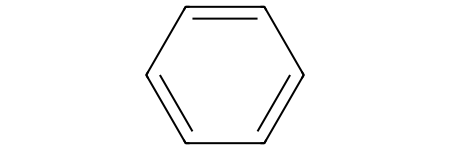

In [3]:
mol_ben

In [4]:
#sdfファイルを読み込んで、複数の分子をMOLオブジェクトで取得
file_path="C:\\Users\\Ono Shuya\\OneDrive\\デスクトップ\\test data\\JAK3_HUMAN-observations.sdf" #rdkitは日本語のパスを読めないのでカレントディレクトリから読み込む
current_path=os.getcwd() #カレントディレクトリを保持
os.chdir(os.path.dirname(file_path)) #カレントディレクトリをファイル保存先フォルダに変更
file_name=os.path.basename(file_path) #ファイル名を取得
suppl=Chem.SDMolSupplier(file_name) #sdfファイルから複数の分子を読み取る
df=PandasTools.LoadSDF(file_name) #dfの作成
os.chdir(current_path) #カレントディレクトリを元に戻す
mols=[x for x in suppl if x is not None] #各オブジェクトをリストに格納
print(len(mols))

870


zinc_id: ZINC000000009851
ortholog_name: JAK3_HUMAN
gene_name: JAK3
affinity: 5.04
chembldocid: 81718
title: None
reference.pubmed_id: None
reference.doi: 10.1039/C0MD00115E
reference.chembl_id: CHEMBL3217494
reference.journal: MedChemComm
reference.year: 2010


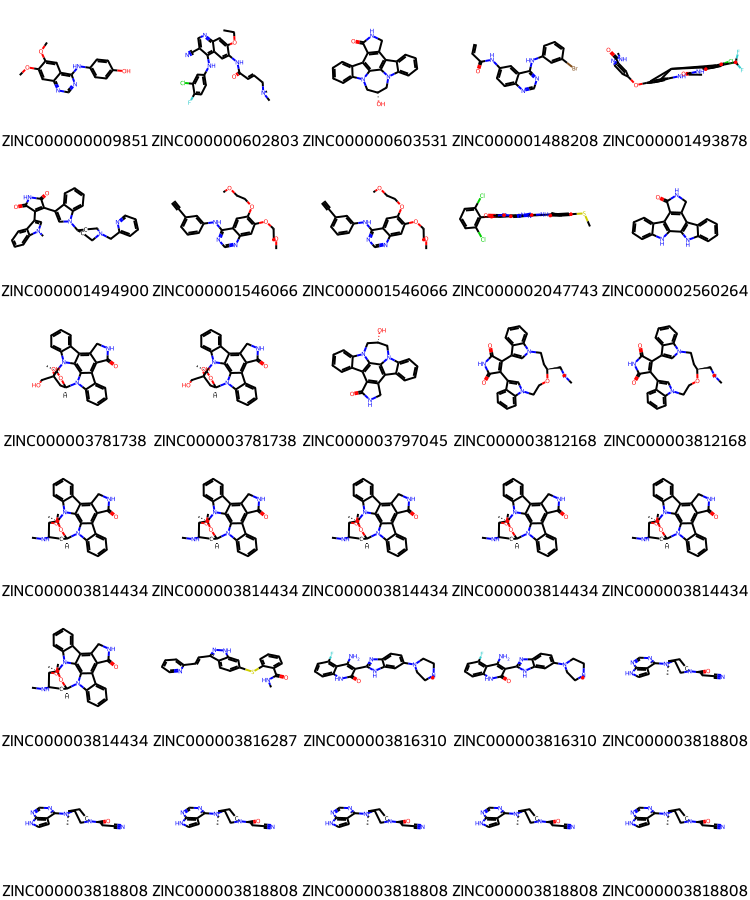

In [5]:
#１番目の分子のプロパティを確認
for prop in mols[0].GetPropNames():
    print("{}: {}".format(prop,mols[0].GetProp(prop)))
#複数の分子画像を描画
Draw.MolsToGridImage(mols[:30],molsPerRow=5,subImgSize=(150,150),legends=[mol.GetProp("zinc_id")for mol in mols]) #30個の分子画像

,zinc_id,ortholog_name,gene_name,affinity,chembldocid,title,reference.pubmed_id,reference.doi,reference.chembl_id,reference.journal,reference.year,ID,ROMol
0,ZINC000000009851,JAK3_HUMAN,JAK3,5.04,81718,None,None,10.1039/C0MD00115E,CHEMBL3217494,MedChemComm,2010,,
1,ZINC000000602803,JAK3_HUMAN,JAK3,7.60,48311,None,18183025,None,CHEMBL1150977,Nat. Biotechnol.,2008,,
2,ZINC000000603531,JAK3_HUMAN,JAK3,6.85,36214,None,17088059,None,CHEMBL1146279,Bioorg. Med. Chem. Lett.,2007,,
3,ZINC000001488208,JAK3_HUMAN,JAK3,5.50,46585,None,18667312,None,CHEMBL1154498,Bioorg. Med. Chem. Lett.,2008,,
4,ZINC000001493878,JAK3_HUMAN,JAK3,5.14,59286,Comprehensive analysis of kinase inhibitor sel...,22037378,None,CHEMBL1908390,Nat. Biotechnol.,2011,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,ZINC000299823628,JAK3_HUMAN,JAK3,7.52,89832,None,25453808,None,CHEMBL3352641,Bioorg. Med. Chem. Lett.,2014,,
866,ZINC000299825521,JAK3_HUMAN,JAK3,5.41,90273,None,24930833,None,CHEMBL3352554,Bioorg. Med. Chem. Lett.,2014,,
867,ZINC000299827384,JAK3_HUMAN,JAK3,6.48,89463,None,25262541,None,CHEMBL3351377,Bioorg. Med. Chem. Lett.,2014,,
868,ZINC000299833998,JAK3_HUMAN,JAK3,5.52,90273,None,24930833,None,CHEMBL3352554,Bioorg. Med. Chem. Lett.,2014,,

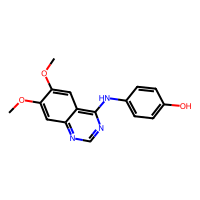
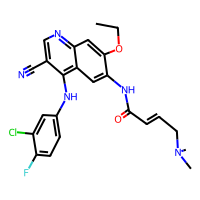
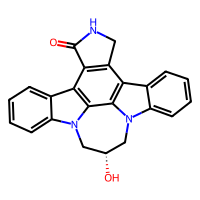
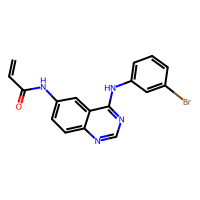
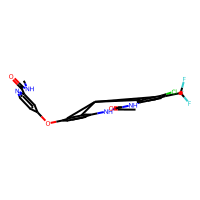
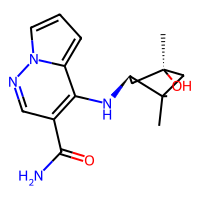
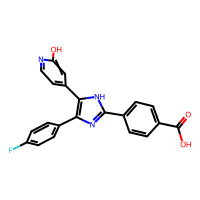
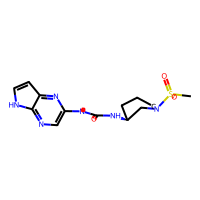
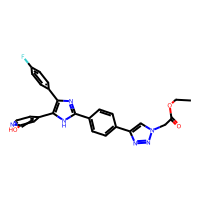
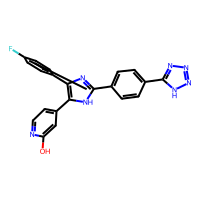

In [6]:
display(df)

In [7]:
#各フィンガープリントの作成、0番目と他をタニモト係数で類似度比較
maccs_fps=[AllChem.GetMACCSKeysFingerprint(mol)for mol in df["ROMol"]] #MACCS Keys
maccs=DataStructs.BulkTanimotoSimilarity(maccs_fps[0],maccs_fps[1:])
rdkit_fps=[Chem.RDKFingerprint(mol)for mol in df["ROMol"]] #RDKitフィンガープリント
rdkit=DataStructs.BulkTanimotoSimilarity(rdkit_fps[0],rdkit_fps[1:])
morgan_fps=[AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)for mol in df["ROMol"]] #Morganフィンガープリント
morgan=DataStructs.BulkTanimotoSimilarity(morgan_fps[0],morgan_fps[1:])

In [8]:
#Morganフィンガープリントを用いて作成した距離行列でButinaクラスタリング
dis_matrix = [] 
for i in range(1, len(morgan_fps)): #各化合物を比較
    similarities = DataStructs.BulkTanimotoSimilarity(morgan_fps[i], morgan_fps[:i],returnDistance = True) #タニモト距離で距離行列を作成
    dis_matrix.extend(similarities) #距離をリストに追加

dis_array=np.array(dis_matrix)
cutoff=0.85#閾値　高いほどクラスターの許容範囲が増える
clusters=Butina.ClusterData(dis_array,len(morgan_fps),cutoff,isDistData=True)
len(clusters)

10

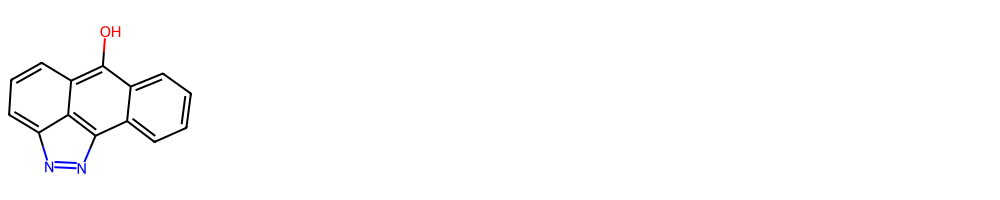

In [9]:
#クラスタの中身を描画
num_cluster_random = np.random.randint(0, len(clusters)) #指定範囲から乱数を生成
cluster_random = [mols[x] for x in clusters[num_cluster_random]] #乱数のクラスタからオブジェクトを取得してリストに格納
Draw.MolsToGridImage(cluster_random, molsPerRow = 5) 

<Figure size 1200x400 with 0 Axes>

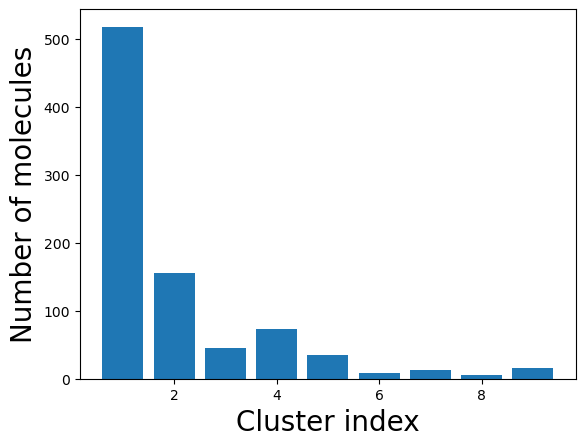

In [10]:
#クラスタごとの要素を取得し、グラフで比較
fig=plt.figure(1,figsize=(12,4))
plt1=plt.subplots(1,1)
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]]) #x軸がクラスタ、y軸が要素数
plt.show()

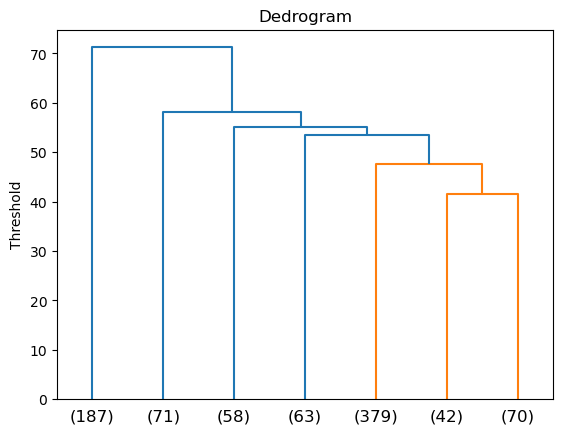

In [11]:
#凝集型クラスタリング、デンドログラムを表示
result=linkage(morgan_fps,metric='euclidean',method='ward') #ユークリッド距離、ウォード法でクラスタリング
dm=dendrogram(result,truncate_mode='lastp', p=7) #クラスタ7個からのデンドログラムを表示
plt.title('Dedrogram')
plt.ylabel('Threshold')
plt.show()

In [12]:
#デンドログラムの情報
clname=[] #クラスタ名
for i in range(len(dm['ivl'])): #各クラスタ
    clname.append(dm['ivl'][i]) #クラスタの要素数を追加
    
print(clname)
print(dm)

['(187)', '(71)', '(58)', '(63)', '(379)', '(42)', '(70)']
{'icoord': [[55.0, 55.0, 65.0, 65.0], [45.0, 45.0, 60.0, 60.0], [35.0, 35.0, 52.5, 52.5], [25.0, 25.0, 43.75, 43.75], [15.0, 15.0, 34.375, 34.375], [5.0, 5.0, 24.6875, 24.6875]], 'dcoord': [[0.0, 41.48391828396246, 41.48391828396246, 0.0], [0.0, 47.65946868926618, 47.65946868926618, 41.48391828396246], [0.0, 53.39052159029902, 53.39052159029902, 47.65946868926618], [0.0, 55.17986782148652, 55.17986782148652, 53.39052159029902], [0.0, 58.07550811838899, 58.07550811838899, 55.17986782148652], [0.0, 71.22956174696452, 71.22956174696452, 58.07550811838899]], 'ivl': ['(187)', '(71)', '(58)', '(63)', '(379)', '(42)', '(70)'], 'leaves': [1730, 1717, 1715, 1716, 1732, 1714, 1728], 'color_list': ['C1', 'C1', 'C0', 'C0', 'C0', 'C0'], 'leaves_color_list': ['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1']}


In [13]:
#kmeansクラスタリング
kmeans=sklearn.cluster.KMeans(n_clusters=7,init='k-means++')
kcl=kmeans.fit(morgan_fps)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
#各要素が割り振られたクラスタを確認
number_of_cluster=[] #各データが所属しているクラスタ番号
number_of_cluster.append(kcl.labels_)
pd.value_counts(kcl.labels_)

2    301
3    187
1    151
0     71
4     63
5     58
6     39
dtype: int64

In [15]:
#dfにクラスタ番号を追加
numb=pd.DataFrame(number_of_cluster).T
new_table=pd.concat([df,numb],axis=1)
new_table=new_table.rename(columns={0: 'cluster_id'})
new_table

,zinc_id,ortholog_name,gene_name,affinity,chembldocid,title,reference.pubmed_id,reference.doi,reference.chembl_id,reference.journal,reference.year,ID,ROMol,cluster_id
0,ZINC000000009851,JAK3_HUMAN,JAK3,5.04,81718,None,None,10.1039/C0MD00115E,CHEMBL3217494,MedChemComm,2010,,<rdkit.Chem.rdchem.Mol object at 0x0000021CD86...,2
1,ZINC000000602803,JAK3_HUMAN,JAK3,7.60,48311,None,18183025,None,CHEMBL1150977,Nat. Biotechnol.,2008,,<rdkit.Chem.rdchem.Mol object at 0x0000021CD86...,2
2,ZINC000000603531,JAK3_HUMAN,JAK3,6.85,36214,None,17088059,None,CHEMBL1146279,Bioorg. Med. Chem. Lett.,2007,,<rdkit.Chem.rdchem.Mol object at 0x0000021CD86...,0
3,ZINC000001488208,JAK3_HUMAN,JAK3,5.50,46585,None,18667312,None,CHEMBL1154498,Bioorg. Med. Chem. Lett.,2008,,<rdkit.Chem.rdchem.Mol object at 0x0000021CD86...,2
4,ZINC000001493878,JAK3_HUMAN,JAK3,5.14,59286,Comprehensive analysis of kinase inhibitor sel...,22037378,None,CHEMBL1908390,Nat. Biotechnol.,2011,,<rdkit.Chem.rdchem.Mol object at 0x0000021CD86...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,ZINC000299823628,JAK3_HUMAN,JAK3,7.52,89832,None,25453808,None,CHEMBL3352641,Bioorg. Med. Chem. Lett.,2014,,<rdkit.Chem.rdchem.Mol object at 0x0000021CDA7...,2
866,ZINC000299825521,JAK3_HUMAN,JAK3,5.41,90273,None,24930833,None,CHEMBL3352554,Bioorg. Med. Chem. Lett.,2014,,<rdkit.Chem.rdchem.Mol object at 0x0000021CDA7...,2
867,ZINC000299827384,JAK3_HUMAN,JAK3,6.48,89463,None,25262541,None,CHEMBL3351377,Bioorg. Med. Chem. Lett.,2014,,<rdkit.Chem.rdchem.Mol object at 0x0000021CDA7...,3
868,ZINC000299833998,JAK3_HUMAN,JAK3,5.52,90273,None,24930833,None,CHEMBL3352554,Bioorg. Med. Chem. Lett.,2014,,<rdkit.Chem.rdchem.Mol object at 0x0000021CDA7...,2


Text(0.5, 1.0, '6-Clusters by k-means')

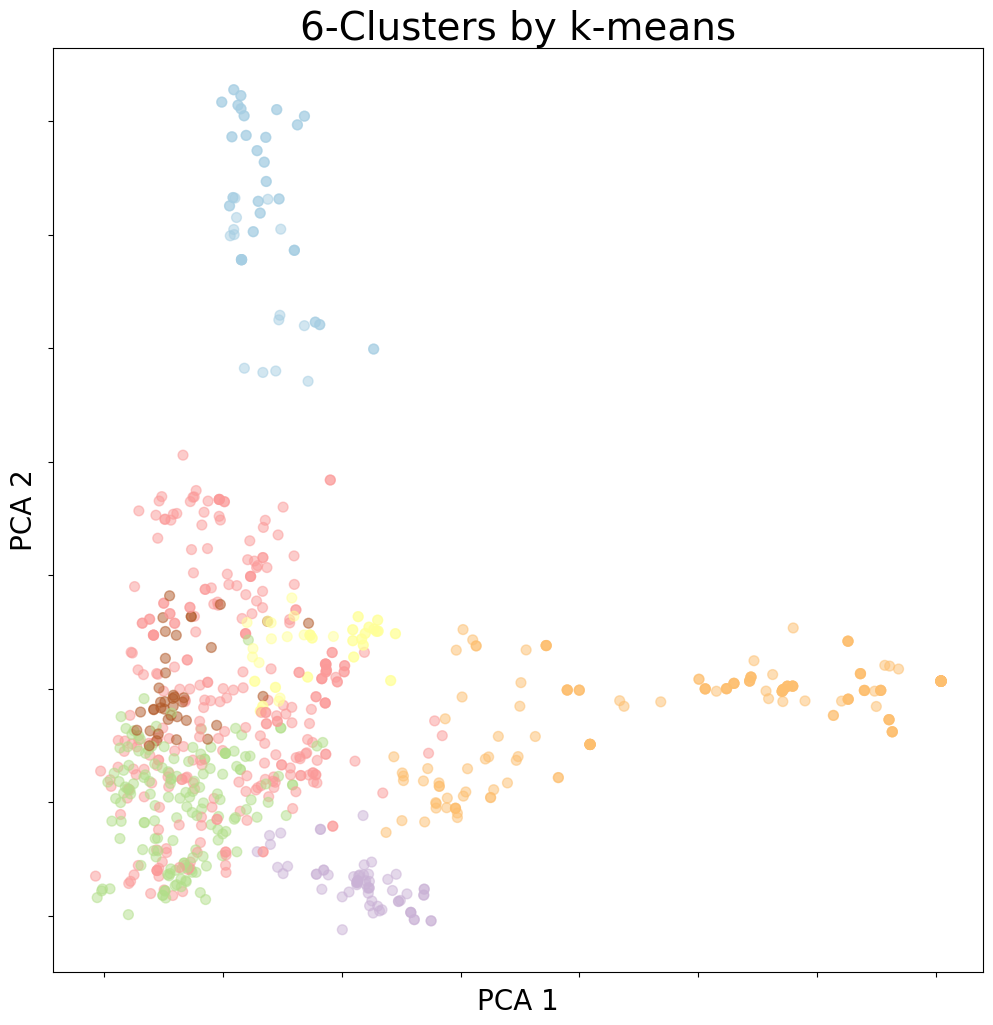

In [16]:
#kmeansクラスタリング結果を可視化
pca=PCA(n_components=2)
pca.fit(morgan_fps)
dis_pca=pca.transform(morgan_fps)
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
ax.scatter(dis_pca[:,0], dis_pca[:,1], s=50, c=kcl.labels_, cmap='Paired', alpha=0.5)
ax.set_xlabel('PCA 1', fontsize=20)
ax.set_xticklabels([])
ax.set_ylabel('PCA 2', fontsize=20)
ax.set_yticklabels([])
ax.set_title('6-Clusters by k-means', fontsize=28)